In [1]:
import os
import math
import numpy as np
import pandas as pd
import requests
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

### Hàm lấy dữ liệu từ CoinGecko

In [2]:
def get_historical_data(coin_id, vs_currency, days):
    url = f'https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart'
    params = {
        'vs_currency': vs_currency,
        'days': days
    }
    response = requests.get(url, params=params)
    data = response.json()
    
    prices = data['prices']
    df = pd.DataFrame(prices, columns=['timestamp', 'price'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df

In [3]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_length]
        y = self.data[idx+self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

class TransformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 5000, embed_dim))
        self.transformer = nn.Transformer(embed_dim, num_heads, num_layers, num_layers, dropout=dropout)
        self.fc = nn.Linear(embed_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        x += self.positional_encoding[:, :x.size(1), :]
        x = self.transformer(x, x)
        x = self.fc(x[:, -1])
        return x

def train_transformer(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}')

def predict_and_save_transformer(coin_id, vs_currency, days, file_path):
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    df = get_historical_data(coin_id, vs_currency, days)
    data = df.filter(['price']).values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    train_data_len = math.ceil(len(scaled_data) * 0.8)
    train_data = scaled_data[:train_data_len]
    test_data = scaled_data[train_data_len - 60:]

    seq_length = 60
    train_dataset = TimeSeriesDataset(train_data, seq_length)
    test_dataset = TimeSeriesDataset(test_data, seq_length)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = TransformerModel(input_dim=1, embed_dim=64, num_heads=4, num_layers=3, dropout=0.1)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_transformer(model, train_loader, criterion, optimizer, epochs=10)

    model.eval()
    predictions = []
    with torch.no_grad():
        for x, _ in test_loader:
            output = model(x)
            predictions.extend(output.detach().cpu().numpy())

    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    valid = df[train_data_len:]
    valid['Predictions'] = predictions

    plt.figure(figsize=(16, 8))
    plt.title(f'Model {coin_id.upper()}-{vs_currency.upper()} Transformer')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(df['price'][:train_data_len], label='Train')
    plt.plot(df['price'][train_data_len:], label='Val')
    plt.plot(valid['Predictions'], label='Predictions')
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

    valid['Date'] = valid.index
    results = valid[['Date', 'price', 'Predictions']]
    results.to_csv(file_path, index=False)

    rmse = np.sqrt(mean_squared_error(valid['price'], valid['Predictions']))
    mae = mean_absolute_error(valid['price'], valid['Predictions'])
    mape = np.mean(np.abs((valid['price'] - valid['Predictions']) / valid['price'])) * 100

    print(f'{coin_id.upper()}-{vs_currency.upper()} Transformer RMSE: {rmse}')
    print(f'{coin_id.upper()}-{vs_currency.upper()} Transformer MAE: {mae}')
    print(f'{coin_id.upper()}-{vs_currency.upper()} Transformer MAPE: {mape}%')

### Dự đoán cho các cặp tiền với Transformer

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/10, Loss: 1.7922
Epoch 2/10, Loss: 0.1320
Epoch 3/10, Loss: 0.1083
Epoch 4/10, Loss: 0.0908
Epoch 5/10, Loss: 0.0890
Epoch 6/10, Loss: 0.1064
Epoch 7/10, Loss: 0.1069
Epoch 8/10, Loss: 0.0925
Epoch 9/10, Loss: 0.0434
Epoch 10/10, Loss: 0.0709


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6824\3325123552.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


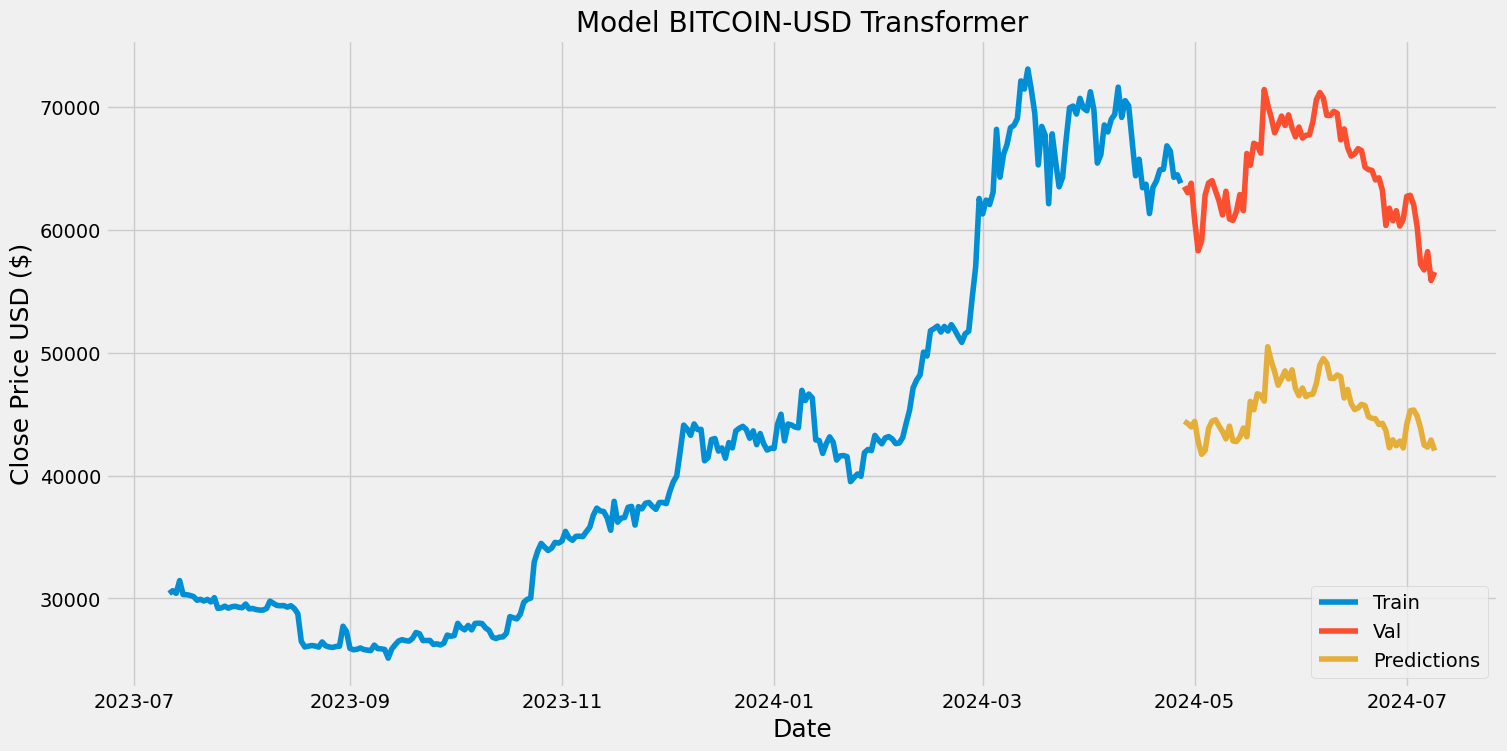

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6824\3325123552.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Date'] = valid.index


BITCOIN-USD Transformer RMSE: 19504.32228731244
BITCOIN-USD Transformer MAE: 19372.716155069305
BITCOIN-USD Transformer MAPE: 29.873250472636993%


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/10, Loss: 1.5565
Epoch 2/10, Loss: 0.0982
Epoch 3/10, Loss: 0.0982
Epoch 4/10, Loss: 0.0940
Epoch 5/10, Loss: 0.0818
Epoch 6/10, Loss: 0.0818
Epoch 7/10, Loss: 0.0651
Epoch 8/10, Loss: 0.0265
Epoch 9/10, Loss: 0.0140
Epoch 10/10, Loss: 0.0110


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6824\3325123552.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


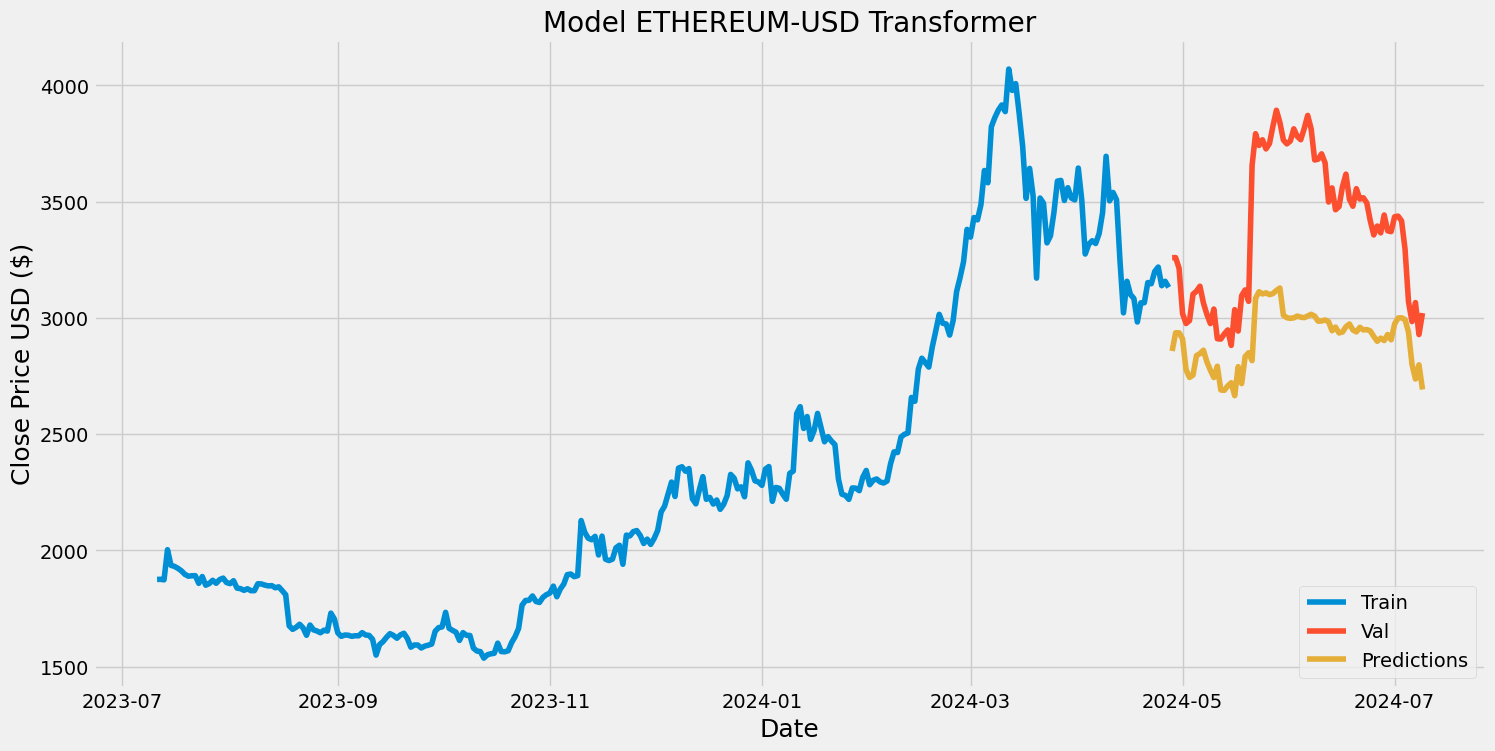

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6824\3325123552.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Date'] = valid.index


ETHEREUM-USD Transformer RMSE: 523.1404898297374
ETHEREUM-USD Transformer MAE: 476.2896590264392
ETHEREUM-USD Transformer MAPE: 13.589720871196864%


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/10, Loss: 1.8594
Epoch 2/10, Loss: 0.1271
Epoch 3/10, Loss: 0.1003
Epoch 4/10, Loss: 0.1081
Epoch 5/10, Loss: 0.1055
Epoch 6/10, Loss: 0.0872
Epoch 7/10, Loss: 0.0832
Epoch 8/10, Loss: 0.0271
Epoch 9/10, Loss: 0.0233
Epoch 10/10, Loss: 0.0244


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6824\3325123552.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


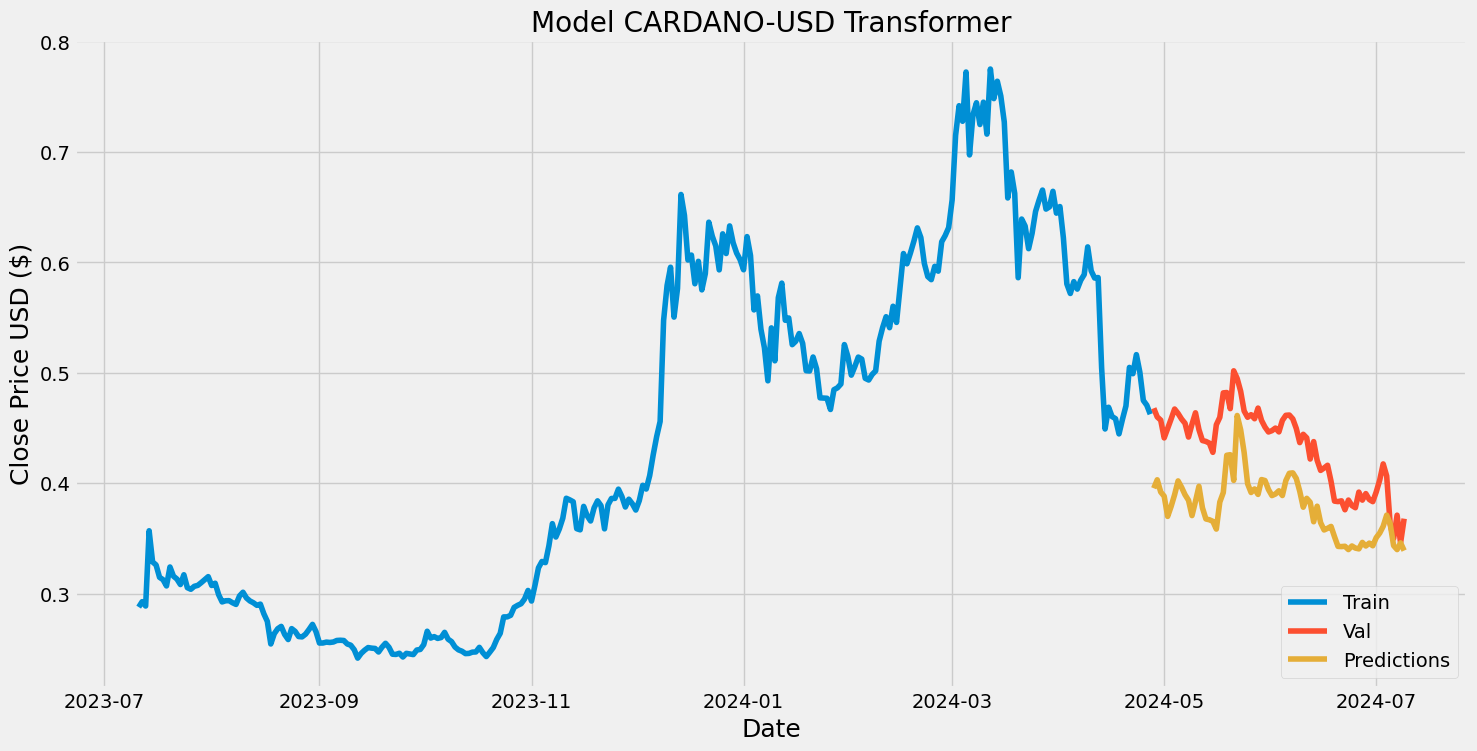

CARDANO-USD Transformer RMSE: 0.05661255323192336
CARDANO-USD Transformer MAE: 0.05332300448594653
CARDANO-USD Transformer MAPE: 12.15746976945669%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6824\3325123552.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Date'] = valid.index


In [4]:
# Dự đoán và lưu kết quả cho BTC-USD
predict_and_save_transformer('bitcoin', 'usd', '365', '../output/Transformer/BTC-USD.csv')

# Dự đoán và lưu kết quả cho ETH-USD
predict_and_save_transformer('ethereum', 'usd', '365', '../output/Transformer/ETH-USD.csv')

# Dự đoán và lưu kết quả cho ADA-USD
predict_and_save_transformer('cardano', 'usd', '365', '../output/Transformer/ADA-USD.csv')